In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install -U scikit-learn
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, lasso_path
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import  GradientBoostingClassifier
from scipy import stats

# Import des fichiers et prétraitement des données

In [ ]:
!pip install PyDrive




In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
downloaded = drive.CreateFile({'id':"1pTMw9g6uYtdOm2JzIpfE_WhRMP6bqOp-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('LFB_Incident_data_ Janv-juil 2015.csv')        # replace the file name with your file
incident = pd.read_csv('LFB_Incident_data_ Janv-juil 2015.csv', sep = ';', encoding='latin-1')
incident.head()

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription specialservice,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending
0,1151,01-janv-15,2015,00:02:15,0,Special Service,RTC,Road Vehicle,Car,In street outside gazetteer location,CR0 5RE,CR0,E09000008,CROYDON,Croydon,E05000162,Selsdon and Ballards,Selsdon and Ballards,534581.0,164369.0,534550,164350,London,Addington,282.0,Addington,NaN,NaN,1.0,2.0
1,4151,01-janv-15,2015,00:03:05,0,Fire,Secondary Fire,Outdoor,Hedge,Correct incident location,EN2 0EW,EN2,E09000010,ENFIELD,Enfield,E05000195,Chase,Chase,532655.0,198115.0,532650,198150,London,Enfield,404.0,Enfield,NaN,NaN,1.0,1.0
2,3151,01-janv-15,2015,00:03:17,0,False Alarm,False alarm - Good intent,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,NW5,E09000007,CAMDEN,Camden,E05000131,Cantelowes,Cantelowes,NaN,NaN,529350,184850,London,Kentish Town,NaN,NaN,NaN,NaN,1.0,1.0
3,8151,01-janv-15,2015,00:04:40,0,Fire,Secondary Fire,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,W7 1NP,W7,E09000009,EALING,Ealing,E05000180,Hobbayne,Hobbayne,515603.0,181226.0,515650,181250,London,Ealing,299.0,Ealing,NaN,NaN,1.0,1.0
4,10151,01-janv-15,2015,00:06:20,0,Special Service,Flooding,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,CR8,E09000008,CROYDON,Croydon,E05000156,Kenley,Kenley,NaN,NaN,531450,159150,London,Purley,401.0,Purley,NaN,NaN,1.0,1.0


In [ ]:
downloaded = drive.CreateFile({'id':"1LojlenbptGrfc1px6ExXXukui20LE8eF"})   # replace the id with id of file you want to access
downloaded.GetContentFile('LFB_Mob_data_Janv-juil_2015.csv')        # replace the file name with your file
mobilisation = pd.read_csv('LFB_Mob_data_Janv-juil_2015.csv', sep = ';')
mobilisation.head()


,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description
0,1151,2015,0,4436381,H262,1,01/01/2015 00:02,01/01/2015 00:03,01/01/2015 00:07,79.0,203.0,282,01/01/2015 00:35,01/01/2015 00:43,H26,Addington,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
1,1151,2015,0,4436380,H261,2,01/01/2015 00:02,01/01/2015 00:03,01/01/2015 00:07,74.0,211.0,285,01/01/2015 00:33,01/01/2015 00:38,H26,Addington,Home Station,2,Initial,Initial Mobilisation,NaN,NaN
2,4151,2015,0,4436383,A352,1,01/01/2015 00:03,01/01/2015 00:03,01/01/2015 00:09,44.0,360.0,404,01/01/2015 00:15,01/01/2015 00:27,A35,Enfield,Home Station,1,Initial,Initial Mobilisation,12.0,Not held up
3,8151,2015,0,4436385,G251,1,01/01/2015 00:04,01/01/2015 00:06,01/01/2015 00:09,76.0,223.0,299,01/01/2015 00:44,01/01/2015 00:50,G25,Ealing,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
4,10151,2015,0,4436390,H291,1,01/01/2015 00:06,01/01/2015 00:11,01/01/2015 00:13,249.0,152.0,401,01/01/2015 00:20,01/01/2015 00:25,H29,Purley,Home Station,1,Initial,Initial Mobilisation,11.0,Mob/Radio problems when mobilised


In [ ]:
df = pd.merge(mobilisation, incident, on = ['IncidentNumber'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75396 entries, 0 to 75395
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IncidentNumber                          75396 non-null  int64  
 1   CalYear_x                               75396 non-null  int64  
 2   HourOfCall_x                            75396 non-null  int64  
 3   ResourceMobilisationId                  75396 non-null  int64  
 4   Resource_Code                           75396 non-null  object 
 5   PerformanceReporting                    75396 non-null  object 
 6   DateAndTimeMobilised                    75396 non-null  object 
 7   DateAndTimeMobile                       74617 non-null  object 
 8   DateAndTimeArrived                      75396 non-null  object 
 9   TurnoutTimeSeconds                      74608 non-null  float64
 10  TravelTimeSeconds                       74614 non-null  fl

In [ ]:
#Suppression colonnes inutiles
df = df.drop(['Easting_m', 'Northing_m'], axis=1)

#Suppression colonnes en double
df = df.drop(['CalYear_y', 'HourOfCall_y', 'ProperCase'], axis=1)

In [ ]:
num_df = df.select_dtypes(exclude=['object'])
cat_df = df.select_dtypes(include=['object'])

In [ ]:
#Remplacement par la moyenne
num_df.fillna(num_df.mean(),inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#Remplacement des valeurs catégorielles manquantes par le mode le  + courant
for i in cat_df:
    df.fillna(df[str(i)].mode()[0],inplace=True)
    
#Vérification
print(df.isna().sum()) #OK

IncidentNumber                            0
CalYear_x                                 0
HourOfCall_x                              0
ResourceMobilisationId                    0
Resource_Code                             0
PerformanceReporting                      0
DateAndTimeMobilised                      0
DateAndTimeMobile                         0
DateAndTimeArrived                        0
TurnoutTimeSeconds                        0
TravelTimeSeconds                         0
AttendanceTimeSeconds                     0
DateAndTimeLeft                           0
DateAndTimeReturned                       0
DeployedFromStation_Code                  0
DeployedFromStation_Name                  0
DeployedFromLocation                      0
PumpOrder                                 0
PlusCode_Code                             0
PlusCode_Description                      0
DelayCodeId                               0
DelayCode_Description                     0
DateOfCall                      

In [ ]:
#Encodage des variables catégorielles
for i in cat_df:
    df[i] = df[i].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75396 entries, 0 to 75395
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   IncidentNumber                          75396 non-null  int64   
 1   CalYear_x                               75396 non-null  int64   
 2   HourOfCall_x                            75396 non-null  int64   
 3   ResourceMobilisationId                  75396 non-null  int64   
 4   Resource_Code                           75396 non-null  category
 5   PerformanceReporting                    75396 non-null  category
 6   DateAndTimeMobilised                    75396 non-null  category
 7   DateAndTimeMobile                       75396 non-null  category
 8   DateAndTimeArrived                      75396 non-null  category
 9   TurnoutTimeSeconds                      75396 non-null  object  
 10  TravelTimeSeconds                       75396 

# Choix et  encodage des variables catégorielles à conserver

In [ ]:
#Variables supprimées
df = df.drop(['IncidentNumber', 'ResourceMobilisationId', 'Resource_Code', 'DateAndTimeMobilised',
'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code'], axis=1)

#Modification variables 'PerformanReporting'
df['PerformanceReporting'].value_counts()
df['PerformanceReporting']= df['PerformanceReporting'].replace(['Not Used'],[3])

In [ ]:
#Suppression valeur aberrante pour 'TravelTimeSeconds' == 'A242' et changement type de la colonne
indexNames = df[(df['TravelTimeSeconds'] == 'A242')].index
df.drop(indexNames , inplace=True)
df['TravelTimeSeconds'] =  df['TravelTimeSeconds'].astype('int64')

In [ ]:
#Modifications types de colonnes pour Performance Reporting
df['PerformanceReporting'] =  df['PerformanceReporting'].astype('int64')

In [ ]:
#Suppression valeur aberrante pour 'TurnoutTimeSeconds' == '002113-06012016' et changement type de la colonne
indexNamesTTS = df[(df['TurnoutTimeSeconds'] == 'A242')].index
df.drop(indexNamesTTS , inplace=True)
df['TurnoutTimeSeconds'] =  df['TurnoutTimeSeconds'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74605 entries, 0 to 75395
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   CalYear_x                               74605 non-null  int64   
 1   HourOfCall_x                            74605 non-null  int64   
 2   PerformanceReporting                    74605 non-null  int64   
 3   TurnoutTimeSeconds                      74605 non-null  int64   
 4   TravelTimeSeconds                       74605 non-null  int64   
 5   AttendanceTimeSeconds                   74605 non-null  int64   
 6   DeployedFromStation_Name                74605 non-null  category
 7   DeployedFromLocation                    74605 non-null  category
 8   PumpOrder                               74605 non-null  int64   
 9   PlusCode_Code                           74605 non-null  category
 10  PlusCode_Description                    74605 

In [ ]:
#Création d'une nouvelle variable encodée à partir du nom de la station et de sa performance à la variable cible
df['StationPerf'] = df['AttendanceTimeSeconds'].groupby(df['DeployedFromStation_Name']).transform('mean').sort_values()


In [ ]:
#Définition des quantiles de StationPerf
df['StationPerf_Classes'] = pd.cut(df.StationPerf, labels=[0,1,2,3,4,5,6,7,8,9], bins = 10)
df['StationPerf_Classes'].value_counts(normalize = True)



1    0.428001
2    0.245640
0    0.152885
3    0.152295
4    0.014999
5    0.005482
6    0.000684
9    0.000013
8    0.000000
7    0.000000
Name: StationPerf_Classes, dtype: float64

In [ ]:
#Création d'une nouvelle variable encodée à partir du lieu de déploiement (centre incendie ou autre)

df['FromLocationPerf'] = df['AttendanceTimeSeconds'].groupby(df['DeployedFromLocation']).transform('mean')

df['FromLocationPerf'] = df['FromLocationPerf'].astype('category')

#Catégorisation de la nouvelle variable
df['FromLocationCat'] = df['FromLocationPerf'].cat.codes



In [ ]:
df['PumpOrder'].value_counts(normalize = True)
#OK on encode pas

1    0.690155
2    0.264969
3    0.040936
4    0.003659
5    0.000188
6    0.000094
Name: PumpOrder, dtype: float64

In [ ]:
#Suppression de la colonne 'PlusCode_Code' qui fait doublon avec 'PlusCode_Description'
df = df.drop(['PlusCode_Code'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74605 entries, 0 to 75395
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   CalYear_x                               74605 non-null  int64   
 1   HourOfCall_x                            74605 non-null  int64   
 2   PerformanceReporting                    74605 non-null  int64   
 3   TurnoutTimeSeconds                      74605 non-null  int64   
 4   TravelTimeSeconds                       74605 non-null  int64   
 5   AttendanceTimeSeconds                   74605 non-null  int64   
 6   DeployedFromStation_Name                74605 non-null  category
 7   DeployedFromLocation                    74605 non-null  category
 8   PumpOrder                               74605 non-null  int64   
 9   PlusCode_Description                    74605 non-null  category
 10  DelayCodeId                             74605 

In [ ]:
#Création d'une nouvelle variable encodée à partir du type de mobilisation (au départ, en plus d'une précédente, durant un trajet)
df['PlusCode_Description_Perf'] = df['AttendanceTimeSeconds'].groupby(df['PlusCode_Description']).transform('mean')
df['PlusCode_Description_Perf'] = df['PlusCode_Description_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['PlusCode_Description_Cat'] = df['PlusCode_Description_Perf'].cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74605 entries, 0 to 75395
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   CalYear_x                               74605 non-null  int64   
 1   HourOfCall_x                            74605 non-null  int64   
 2   PerformanceReporting                    74605 non-null  int64   
 3   TurnoutTimeSeconds                      74605 non-null  int64   
 4   TravelTimeSeconds                       74605 non-null  int64   
 5   AttendanceTimeSeconds                   74605 non-null  int64   
 6   DeployedFromStation_Name                74605 non-null  category
 7   DeployedFromLocation                    74605 non-null  category
 8   PumpOrder                               74605 non-null  int64   
 9   PlusCode_Description                    74605 non-null  category
 10  DelayCodeId                             74605 

In [ ]:
df['DelayCodeId'].value_counts(normalize = True)

#Suppression de DelayCodeId et DelayCode_Description, non pertinentes dans le cadre d'un moèdle prédictif
df = df.drop(['DelayCodeId', 'DelayCode_Description'], axis=1)

In [ ]:
###Traitement de la colonne df['DateOfCall']

#Création de la fonction get_day
def get_day(date):
    splits =  date.split('-')
    day =  splits[0]
    return day

#Création de la fonction get_month
def get_month(date):
    splits =  date.split('-')
    month =  splits[1]
    return month

#Création de la fonction get_year
def get_year(date):
    splits =  date.split('-')
    year =  splits[2]
    return year

#stockage des variables
days = df['DateOfCall'].apply(get_day)
months = df['DateOfCall'].apply(get_month)
years = df['DateOfCall'].apply(get_year)

#création des 3 nouvelles colonnes
df['day']   = days
df['month'] = months
df['year']  = years

df['month'].value_counts(normalize = True)

juil    0.170498
juin    0.156317
mai     0.142511
avr     0.140674
mars    0.137069
janv    0.135353
févr    0.117579
Name: month, dtype: float64

In [ ]:
#Modification mois
df.month = df.month.replace(['janv', 'févr', 'mars', 'avr', 'mai', 'juin', 'juil'], ['01', '02', '03', '04', '05', '06', '07'])
df['month'].value_counts()

#création d'une nouvelle variable 'date'
df['date'] = df['day'].astype('str') + '-' + df['month'].astype('str') + '-' + df['year'].astype('str')
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74605 entries, 0 to 75395
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   CalYear_x                               74605 non-null  int64         
 1   HourOfCall_x                            74605 non-null  int64         
 2   PerformanceReporting                    74605 non-null  int64         
 3   TurnoutTimeSeconds                      74605 non-null  int64         
 4   TravelTimeSeconds                       74605 non-null  int64         
 5   AttendanceTimeSeconds                   74605 non-null  int64         
 6   DeployedFromStation_Name                74605 non-null  category      
 7   DeployedFromLocation                    74605 non-null  category      
 8   PumpOrder                               74605 non-null  int64         
 9   PlusCode_Description                    74605 non-

In [ ]:
df['Hours']=pd.to_datetime(df['TimeOfCall'],format='%H:%M:%S')
df['Hours'] = df['Hours'].dt.time
df['Hours']=pd.to_datetime(df['Hours'],format='%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74605 entries, 0 to 75395
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   CalYear_x                               74605 non-null  int64         
 1   HourOfCall_x                            74605 non-null  int64         
 2   PerformanceReporting                    74605 non-null  int64         
 3   TurnoutTimeSeconds                      74605 non-null  int64         
 4   TravelTimeSeconds                       74605 non-null  int64         
 5   AttendanceTimeSeconds                   74605 non-null  int64         
 6   DeployedFromStation_Name                74605 non-null  category      
 7   DeployedFromLocation                    74605 non-null  category      
 8   PumpOrder                               74605 non-null  int64         
 9   PlusCode_Description                    74605 non-

In [ ]:
#Création d'une nouvelle variable à partir du type d'incident/performence moyenne
df['IncidentGroup_Perf'] = df['AttendanceTimeSeconds'].groupby(df['IncidentGroup']).transform('mean')
df['IncidentGroup_Perf'] = df['IncidentGroup_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['IncidentGroup_Perf_Cat'] = df['IncidentGroup_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir du Stop Code/performence moyenne
df['StopCodeDescription_Perf'] = df['AttendanceTimeSeconds'].groupby(df['StopCodeDescription specialservice']).transform('mean')
df['StopCodeDescription_Perf'] = df['StopCodeDescription_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['StopCodeDescription_Perf_Cat'] = df['StopCodeDescription_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir de Catégorie de Bien/performence moyenne
df['PropertyCategory_Perf'] = df['AttendanceTimeSeconds'].groupby(df['PropertyCategory']).transform('mean')
df['PropertyCategory_Perf'] = df['PropertyCategory_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['PropertyCategory_Perf_Cat'] = df['PropertyCategory_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir du Type de Bien/performence moyenne
df['PropertyType_Perf'] = df['AttendanceTimeSeconds'].groupby(df['PropertyType']).transform('mean')
df['PropertyType_Perf'] = df['PropertyType_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['PropertyType_Perf_Cat'] = df['PropertyType_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir de la précision de l'adresse/performence moyenne
df['AddressQualifier_Perf'] = df['AttendanceTimeSeconds'].groupby(df['AddressQualifier']).transform('mean')
df['AddressQualifier_Perf'] = df['AddressQualifier_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['AddressQualifier_Perf_Cat'] = df['AddressQualifier_Perf'].cat.codes

#On laisse tomber 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode'
df = df.drop(['Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode'], axis=1)

In [ ]:
#Création d'une nouvelle variable à partir de la précision de l'adresse/performence moyenne
df['IncGeo_BoroughName_Perf'] = df['AttendanceTimeSeconds'].groupby(df['IncGeo_BoroughName']).transform('mean')
df['IncGeo_BoroughName_Perf'] = df['IncGeo_BoroughName_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['IncGeo_BoroughName_Perf_Cat'] = df['IncGeo_BoroughName_Perf'].cat.codes

#On laisse tomber 'IncGeo_WardCode', 'IncGeo_WardName'
df = df.drop(['IncGeo_WardCode', 'IncGeo_WardName'], axis=1)

In [ ]:
#Création d'une nouvelle variable à partir de IncGeo_WardNameNew/performence moyenne
df['IncGeo_WardNameNew_Perf'] = df['AttendanceTimeSeconds'].groupby(df['IncGeo_WardNameNew']).transform('mean')
df['IncGeo_WardNameNew_Perf'] = df['IncGeo_WardNameNew_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['IncGeo_WardNameNew_Perf_Cat'] = df['IncGeo_WardNameNew_Perf'].cat.codes

In [ ]:
#On laisse tomber 'Easting_rounded', 'Northing_rounded'
df = df.drop(['Easting_rounded', 'Northing_rounded'], axis=1)

#Création d'une nouvelle variable à partir de Londres et sa banlieue/performence moyenne
df['FRS_Perf'] = df['AttendanceTimeSeconds'].groupby(df['FRS']).transform('mean')
df['FRS_Perf'] = df['FRS_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['FRS_Perf_Cat'] = df['FRS_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir de la station d'incident/performence moyenne
df['IncidentStationGround_Perf'] = df['AttendanceTimeSeconds'].groupby(df['IncidentStationGround']).transform('mean')
df['IncidentStationGround_Perf'] = df['IncidentStationGround_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['IncidentStationGround_Perf_Cat'] = df['IncidentStationGround_Perf'].cat.codes

In [ ]:
#Création d'une nouvelle variable à partir de la station de déploiement du premier Fourgon incendie/performence moyenne
df['FirstPumpArriving_DeployedFromStation_Perf'] = df['AttendanceTimeSeconds'].groupby(df['FirstPumpArriving_DeployedFromStation']).transform('mean')
df['FirstPumpArriving_DeployedFromStation_Perf'] = df['FirstPumpArriving_DeployedFromStation_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['FirstPumpArriving_DeployedFromStation_Perf_Cat'] = df['FirstPumpArriving_DeployedFromStation_Perf'].cat.codes

#Création d'une nouvelle variable à partir de la station de déploiement de la second Fourgon incendie/performence moyenne
df['SecondPumpArriving_DeployedFromStation_Perf'] = df['AttendanceTimeSeconds'].groupby(df['SecondPumpArriving_DeployedFromStation']).transform('mean')
df['SecondPumpArriving_DeployedFromStation_Perf'] = df['SecondPumpArriving_DeployedFromStation_Perf'].astype('category')

#Catégorisation de la nouvelle variable
df['SecondPumpArriving_DeployedFromStation_Perf_Cat'] = df['SecondPumpArriving_DeployedFromStation_Perf'].cat.codes


In [ ]:
df['NumPumpsAttending'].value_counts(normalize = True)
#OK on encode pas

2.0     0.457208
1.0     0.381355
3.0     0.133503
4.0     0.022867
6.0     0.002225
5.0     0.001863
7.0     0.000362
8.0     0.000241
10.0    0.000107
11.0    0.000040
12.0    0.000040
13.0    0.000040
23.0    0.000040
16.0    0.000027
14.0    0.000027
15.0    0.000027
19.0    0.000013
9.0     0.000013
Name: NumPumpsAttending, dtype: float64

In [ ]:
df.head(10)

,CalYear_x,HourOfCall_x,PerformanceReporting,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Description,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription specialservice,PropertyCategory,PropertyType,AddressQualifier,IncGeo_BoroughName,IncGeo_WardNameNew,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,StationPerf,StationPerf_Classes,FromLocationPerf,FromLocationCat,PlusCode_Description_Perf,PlusCode_Description_Cat,day,month,year,date,Hours,IncidentGroup_Perf,IncidentGroup_Perf_Cat,StopCodeDescription_Perf,StopCodeDescription_Perf_Cat,PropertyCategory_Perf,PropertyCategory_Perf_Cat,PropertyType_Perf,PropertyType_Perf_Cat,AddressQualifier_Perf,AddressQualifier_Perf_Cat,IncGeo_BoroughName_Perf,IncGeo_BoroughName_Perf_Cat,IncGeo_WardNameNew_Perf,IncGeo_WardNameNew_Perf_Cat,FRS_Perf,FRS_Perf_Cat,IncidentStationGround_Perf,IncidentStationGround_Perf_Cat,FirstPumpArriving_DeployedFromStation_Perf,FirstPumpArriving_DeployedFromStation_Perf_Cat,SecondPumpArriving_DeployedFromStation_Perf,SecondPumpArriving_DeployedFromStation_Perf_Cat
0,2015,0,1,79,203,282,Addington,Home Station,1,Initial Mobilisation,01-janv-15,00:02:15,Special Service,RTC,Road Vehicle,Car,In street outside gazetteer location,CROYDON,Selsdon and Ballards,London,Addington,282,Addington,A242,A242,1.0,2.0,353.627002,1,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:02:15,364.625551,1,389.885492,23,391.163711,5,391.332300,172,354.871899,1,360.885006,14,428.081633,592,362.358164,0,339.724051,26,357.908072,41,363.06198,0
1,2015,0,2,74,211,285,Addington,Home Station,2,Initial Mobilisation,01-janv-15,00:02:15,Special Service,RTC,Road Vehicle,Car,In street outside gazetteer location,CROYDON,Selsdon and Ballards,London,Addington,282,Addington,A242,A242,1.0,2.0,353.627002,1,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:02:15,364.625551,1,389.885492,23,391.163711,5,391.332300,172,354.871899,1,360.885006,14,428.081633,592,362.358164,0,339.724051,26,357.908072,41,363.06198,0
2,2015,0,1,44,360,404,Enfield,Home Station,1,Initial Mobilisation,01-janv-15,00:03:05,Fire,Secondary Fire,Outdoor,Hedge,Correct incident location,ENFIELD,Chase,London,Enfield,404,Enfield,A242,A242,1.0,1.0,397.319652,2,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:03:05,370.491999,2,370.652261,15,397.393014,6,402.911263,193,358.418600,2,397.415896,27,559.639344,703,362.358164,0,413.491506,89,411.586527,86,363.06198,0
3,2015,0,1,76,223,299,Ealing,Home Station,1,Initial Mobilisation,01-janv-15,00:04:40,Fire,Secondary Fire,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,EALING,Hobbayne,London,Ealing,299,Ealing,A242,A242,1.0,1.0,324.769981,0,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:04:40,370.491999,2,370.652261,15,397.393014,6,397.189123,183,385.387952,4,371.510592,17,426.576000,590,362.358164,0,366.259259,47,344.916129,27,363.06198,0
4,2015,0,1,249,152,401,Purley,Home Station,1,Initial Mobilisation,01-janv-15,00:06:20,Special Service,Flooding,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,CROYDON,Kenley,London,Purley,401,Purley,A242,A242,1.0,1.0,419.638554,3,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:06:20,364.625551,1,364.132754,10,363.750257,4,368.519078,140,358.418600,2,360.885006,14,551.117647,699,362.358164,0,513.221477,101,427.629213,93,363.06198,0
5,2015,0,1,32,330,362,Southgate,Home Station,1,Initial Mobilisation,01-janv-15,00:07:35,Fire,Primary Fire,Dwelling,Converted Flat/Maisonette - Up to 2 storeys,Within same building,ENFIELD,Highlands,London,Enfield,362,Southgate,A242,A242,2.0,2.0,384.516699,2,360.176022,0,362.972021,1,01,01,15,2015-01-01,1900-01-01 00:07:35,370.491999,2,370.358336,13,363.750257,4,342.9514

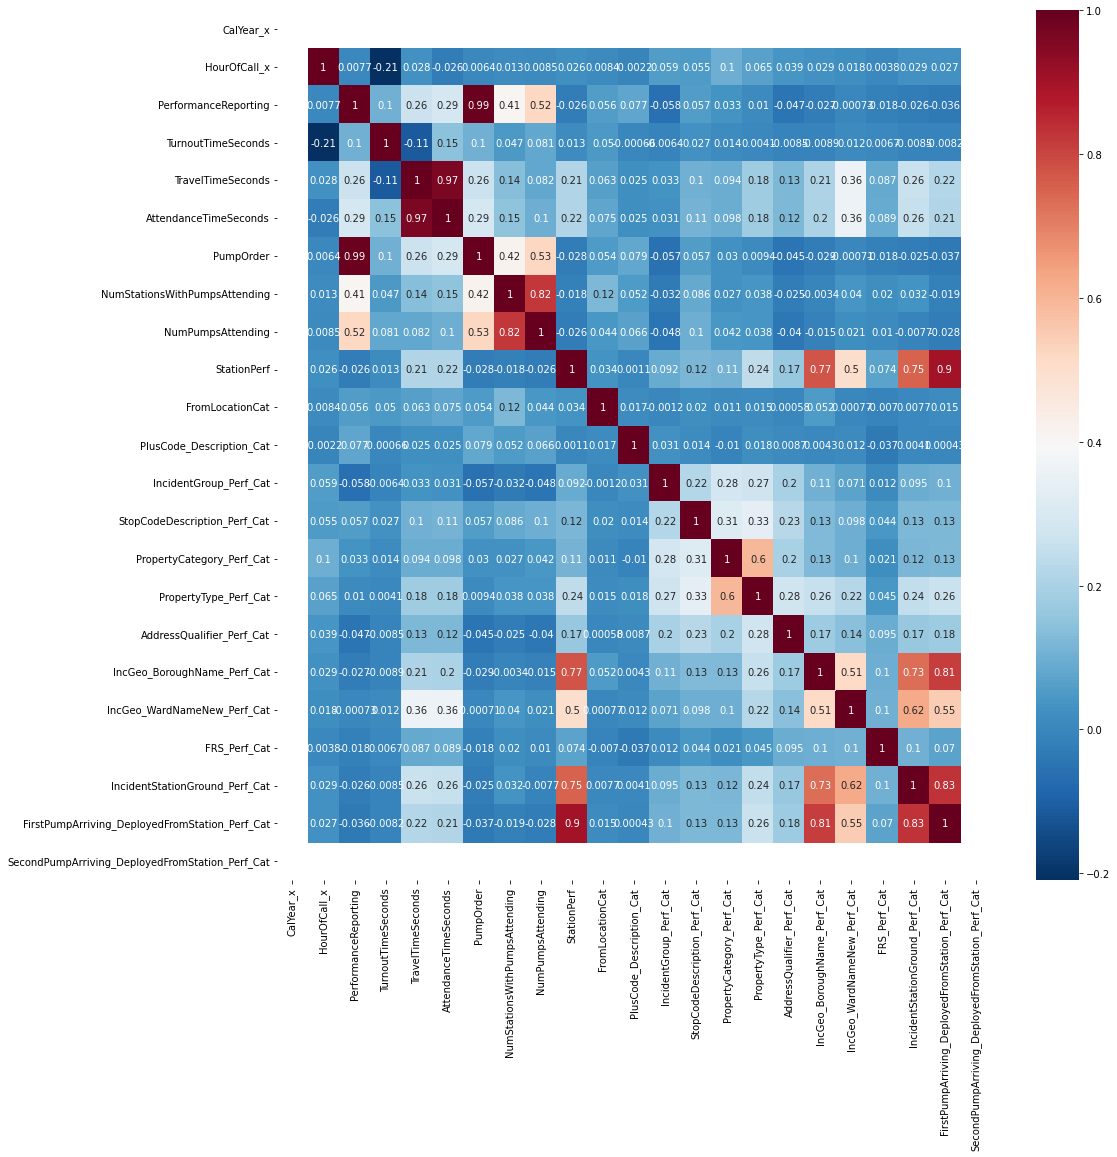

In [ ]:
# Corrélation
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r')

# Mise en place des modèles de test et d'apprentissage

In [ ]:
#Séparation variable cible et features
target = df['AttendanceTimeSeconds']
data = df[['PerformanceReporting','StationPerf_Classes','FromLocationCat','IncidentStationGround_Perf_Cat','StopCodeDescription_Perf_Cat','PropertyCategory_Perf_Cat','PropertyType_Perf_Cat','AddressQualifier_Perf_Cat','IncGeo_BoroughName_Perf_Cat','IncGeo_WardNameNew_Perf_Cat','FRS_Perf_Cat','IncidentStationGround_Perf_Cat','FirstPumpArriving_DeployedFromStation_Perf_Cat','SecondPumpArriving_DeployedFromStation_Perf_Cat','NumStationsWithPumpsAttending','NumPumpsAttending']]

In [ ]:
# création d'un set d'entraînement et d'un set de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [ ]:
# Normalisation (Centrer et réduire)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modèle n° 1 : Régression Lineaire

In [ ]:
# Modèle n° 1 : Régression Lineaire
model_1 = LinearRegression()

model_1.fit(X_train, y_train)

LinearRegression()

In [ ]:
## A revoir

# Afficher le score et le rmse sur l'échantillon et le test
print('score train :', model_1.score(X_train, y_train))
print('score test:', model_1.score(X_test, y_test))

pred_1 = model_1.predict(X_train)
pred_test = model_1.predict(X_test)

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_1)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

print('mae train :', mean_absolute_error(y_train, pred_1))
print('mae test :', mean_absolute_error(y_test, pred_test))

print('R square value train :' , r2_score(y_train, pred_1))
print('R square value test :' , r2_score(y_test, pred_test))

print('corrpearson: ', stats.pearsonr(y_test, pred_test))
print('r-sqr: ', stats.linregress(y_test, pred_test)[2] ** 2)

score train : 0.2512864272876134
score test: 0.24700084356216423
rmse train : 134.18350765452087
rmse test : 135.69695796510592
mae train : 94.64169427444634
mae test : 94.89348267809908
R square value train : 0.2512864272876134
R square value test : 0.24700084356216423
corrpearson:  (0.4970093847255511, 0.0)
r-sqr:  0.24701832850527083


In [ ]:
# Afficher le score et le rmse sur l'échantillon et le test
print('score train :', model_1.score(X_train, y_train))
print('score test:', model_1.score(X_test, y_test))

pred_1 = model_1.predict(X_train)
pred_test = model_1.predict(X_test)

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_1)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

print('mae train :', mean_absolute_error(y_train, pred_1))
print('mae test :', mean_absolute_error(y_test, pred_test))

print('R square value train :' , r2_score(y_train, pred_1))
print('R square value test :' , r2_score(y_test, pred_test))

print('corrpearson: ', stats.pearsonr(y_test, pred_test))
print('r-sqr: ', stats.linregress(y_test, pred_test)[2] ** 2)

score train : 0.2512864272876134
score test: 0.24700084356216423
rmse train : 134.18350765452087
rmse test : 135.69695796510592
mae train : 94.64169427444634
mae test : 94.89348267809908
R square value train : 0.2512864272876134
R square value test : 0.24700084356216423
corrpearson:  (0.4970093847255511, 0.0)
r-sqr:  0.24701832850527083


## Modèle n°2 : Ridge

In [ ]:
# Modèle n°2 : Ridge 

model_2 = RidgeCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
model_2.fit(X_train, y_train)

print('alpha sélectionné par c-v :', model_2.alpha_)

alpha sélectionné par c-v : 1.0


In [ ]:
## A revoir

pred_2 = model_2.predict(X_train_scaled)
pred_test_2 = model_2.predict(X_test_scaled)

print('score train :', model_2.score(X_train, y_train))
print('score test :', model_2.score(X_test, y_test))

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_2)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test_2)))

print('mae train :', mean_absolute_error(y_train, pred_2))
print('mae test :', mean_absolute_error(y_test, pred_test_2))

print('R square value train :' , r2_score(y_train, pred_2))
print('R square value test :' , r2_score(y_test, pred_test_2))

print('corrpearson: ', stats.pearsonr(y_test, pred_test_2))
print('r-sqr: ', stats.linregress(y_test, pred_test_2)[2] ** 2)

score train : 0.2512862912401209
score test : 0.24702739236899607
rmse train : 328.8552328808459
rmse test : 336.2568386732908
mae train : 264.2584654102547
mae test : 265.72787759877076
R square value train : -3.4970419520040537
R square value test : -3.623773134780655
corrpearson:  (0.21642206184375132, 1.1792026836481216e-157)
r-sqr:  0.046838508852700494


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


## Modèle n°3 : KNN K plus proches voisins

In [ ]:
# Modèle n°3 : KNN K plus proches voisins
#Création du classificateur KNN (model_3)
model_3 = neighbors.KNeighborsRegressor(n_neighbors=5, metric='minkowski')


# Meilleurs paramètres 
parameters = {"n_neighbors": range(1, 50)}

#Model selection
grid_model_3 = model_selection.HalvingGridSearchCV(estimator=model_3, param_grid=parameters)

#Affichacge grille
grille_model_3 = grid_model_3.fit(X_train, y_train)

print(pd.DataFrame.from_dict(grille_model_3.cv_results_).loc[:,["params","mean_test_score"]])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names


                 params  mean_test_score
0    {'n_neighbors': 1}        -0.565041
1    {'n_neighbors': 2}        -0.244344
2    {'n_neighbors': 3}        -0.116949
3    {'n_neighbors': 4}        -0.048987
4    {'n_neighbors': 5}        -0.001636
..                  ...              ...
69  {'n_neighbors': 49}         0.140159
70  {'n_neighbors': 46}         0.139782
71  {'n_neighbors': 47}         0.139882
72  {'n_neighbors': 48}         0.158420
73  {'n_neighbors': 49}         0.158414

[74 rows x 2 columns]


In [ ]:
#Affichage hyperparamètres retenus
print(grid_model_3.best_params_)

{'n_neighbors': 48}


In [ ]:
# Application du meilleur paramètre au Modèle n°3
model_3 = neighbors.KNeighborsRegressor(n_neighbors=48, metric='minkowski')

model_3.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=48)

In [ ]:
#Afficher le score et le rmse sur l'échantillon et le test
print('score train :', model_3.score(X_train, y_train))
print('score test:', model_3.score(X_test, y_test))

pred_3 = model_3.predict(X_train)
pred_test_3 = model_3.predict(X_test)

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred_3)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test_3)))

print('mae train :', mean_absolute_error(y_train, pred_3))
print('mae test :', mean_absolute_error(y_test, pred_test_3))

print('R square value train :' , r2_score(y_train, pred_3))
print('R square value test :' , r2_score(y_test, pred_test_3))

print('corrpearson: ', stats.pearsonr(y_test, pred_test_3))
print('r-sqr: ', stats.linregress(y_test, pred_test_3)[2] ** 2)

cm3=pd.crosstab(y_test, pred_test_3, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm3

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"


score train : 0.19638452531248785


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"


score test: 0.15976310725695475


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"


rmse train : 139.01620640992974
rmse test : 143.34209256843965
mae train : 98.55041098395998
mae test : 100.71228609565937
R square value train : 0.19638452531248785
R square value test : 0.15976310725695475
corrpearson:  (0.4018606814156245, 0.0)
r-sqr:  0.16149200726782995


Classe prédite,176.604167,178.187500,179.437500,183.687500,185.437500,187.312500,187.729167,193.333333,198.770833,204.645833,204.875000,205.312500,207.208333,208.020833,208.708333,209.270833,209.395833,209.583333,210.666667,210.854167,211.250000,211.437500,212.187500,213.479167,214.145833,214.583333,215.104167,215.270833,215.541667,216.020833,216.104167,216.395833,217.479167,218.958333,219.500000,221.750000,222.437500,222.562500,222.666667,222.687500,...,627.604167,628.020833,628.854167,629.979167,630.520833,630.916667,631.145833,631.270833,631.479167,631.791667,631.979167,633.479167,634.333333,635.000000,635.791667,635.979167,636.791667,637.145833,637.354167,638.541667,641.645833,643.083333,643.416667,644.770833,645.375000,648.625000,648.666667,649.437500,651.041667,652.291667,653.479167,653.833333,654.979167,656.062500,659.125000,676.062500,678.250000,684.312500,684.437500,688.208333
Classe réelle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modèle n°4 : Lasso

In [ ]:
model_4 = Lasso_r = Lasso(alpha=1)

model_4.fit(X_train, y_train)

Lasso(alpha=1)

In [ ]:
from sklearn.linear_model import lasso_path

mes_alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)

alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=mes_alphas)

coefs_lasso.shape

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484474382.2541356, tolerance: 930511.6244000001
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482000286.10946774, tolerance: 930511.6244000001
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478173982.43432724, tolerance: 930511.6244000001
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474780529.

(16, 10)

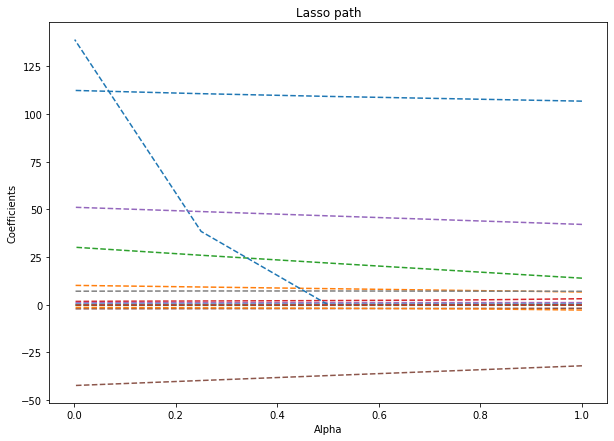

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 7))

for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i,:], '--')

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');



In [ ]:
print('score de train : ', model_4.score(X_train, y_train))
print('score de test : ', model_4.score(X_test, y_test))

model_4_pred_train = model_4.predict(X_train)
model_4_pred_test = model_4.predict(X_test)

print('rmse train : ', np.sqrt(mean_squared_error(y_train, model_4_pred_train)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, model_4_pred_test)))

print('mae train :', mean_absolute_error(y_train, model_4_pred_train))
print('mae test :', mean_absolute_error(y_test, model_4_pred_test))

print('R square value train :' , r2_score(y_train, model_4_pred_train))
print('R square value test :' , r2_score(y_test, model_4_pred_test))

print('corrpearson: ', stats.pearsonr(y_test, model_4_pred_test))
print('r-sqr: ', stats.linregress(y_test, model_4_pred_test)[2] ** 2)

cm4=pd.crosstab(y_test, model_4_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm4

score de train :  0.2463913365166711
score de test :  0.24761155761184483
rmse train :  134.62143903652472
rmse test :  135.64191882726888
mae train : 94.84381092395374
mae test : 94.87827919339506
R square value train : 0.2463913365166711
R square value test : 0.24761155761184483
corrpearson:  (0.4982845776475163, 0.0)
r-sqr:  0.24828752032136356


Classe prédite,135.114301,184.514776,185.173572,190.777562,194.695336,196.867246,198.961754,199.844572,199.977629,200.214511,202.686879,202.702600,203.766214,204.625916,204.652963,204.774866,204.895692,205.478024,205.913963,206.873922,207.051977,208.054710,208.545009,209.165849,209.185844,209.449882,209.479915,209.533941,209.540637,209.581284,209.635949,210.243600,210.331821,210.412111,210.923231,211.921459,212.344487,212.779027,213.492944,214.039482,...,586.910992,587.364621,587.656548,588.907064,589.095738,591.389135,591.809058,594.100235,595.015856,595.222587,598.472094,599.232734,599.379018,599.420718,599.998228,600.586346,600.705603,602.895577,603.633896,604.127716,607.888456,608.779196,609.461724,609.734239,612.023507,614.651401,617.335920,620.257663,622.254832,622.783044,626.032939,627.833463,631.741098,631.939336,649.719164,650.908733,657.736104,659.769530,668.784897,671.438584
Classe réelle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
model_4bis = Lasso_r = Lasso(alpha=0.001)

model_4bis.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.033e+08, tolerance: 1.435e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.001)

In [ ]:
print('score de train : ', model_4bis.score(X_train, y_train))
print('score de test : ', model_4bis.score(X_test, y_test))

model_4bis_pred_train = model_4bis.predict(X_train)
model_4bis_pred_test = model_4bis.predict(X_test)

print('rmse train : ', np.sqrt(mean_squared_error(y_train, model_4bis_pred_train)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, model_4bis_pred_test)))

print('mae train :', mean_absolute_error(y_train, model_4bis_pred_train))
print('mae test :', mean_absolute_error(y_test, model_4bis_pred_test))

print('R square value train :' , r2_score(y_train, model_4bis_pred_train))
print('R square value test :' , r2_score(y_test, model_4bis_pred_test))

print('corrpearson: ', stats.pearsonr(y_test, model_4bis_pred_test))
print('r-sqr: ', stats.linregress(y_test, model_4bis_pred_test)[2] ** 2)

cm4=pd.crosstab(y_test, model_4bis_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm4

score de train :  0.25128640855368656
score de test :  0.24701184985708768
rmse train :  134.1835093332563
rmse test :  135.69596624673252
mae train : 94.64166244850314
mae test : 94.89281260460454
R square value train : 0.25128640855368656
R square value test : 0.24701184985708768
corrpearson:  (0.4970208526496798, 0.0)
r-sqr:  0.24702972796861442


Classe prédite,88.289939,129.431588,151.178965,168.692858,173.900843,176.827414,184.542025,184.570384,186.090237,188.128456,190.658220,191.117038,191.890447,192.076805,193.689388,193.883046,194.849163,194.863310,195.289047,197.031992,197.102469,197.682307,197.827278,198.385303,198.584766,198.650991,198.652012,198.957531,199.244655,199.555156,199.897705,201.054146,201.645363,201.747247,201.758867,201.769938,201.901800,202.665395,202.679940,202.778367,...,628.633801,629.203253,632.405810,634.272493,634.400005,634.582956,636.215475,636.256470,638.963137,641.873868,642.815731,643.729596,646.806008,647.164008,654.449288,657.119362,658.713787,660.702418,663.730260,664.117518,667.096914,668.377333,669.752787,672.519846,673.252655,674.138544,675.241769,675.908862,677.135347,679.471454,680.261384,683.295962,684.156443,707.264986,707.340228,708.484054,722.206714,739.220320,758.204016,769.828990
Classe réelle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modèle n°5 : ElasticNetCV

In [ ]:
# Modèle n°5 : ElasticNetCV
model_5 = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99),
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

model_5.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374855168.51239747, tolerance: 125697.03240939818
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2189333.0686416626, tolerance: 125697.03240939818
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30852648.136805773, tolerance: 125697.03240939818
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:642: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150909

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [ ]:
print('score train :', model_5.score(X_train, y_train))
print('score test :', model_5.score(X_test, y_test))

model_5_pred_train = model_5.predict(X_train)
model_5_test = model_5.predict(X_test)

print('rmse train :',np.sqrt(mean_squared_error(model_5_pred_train, y_train)))
print('rmse test :',np.sqrt(mean_squared_error(model_5_test, y_test)))

print('mae train :', mean_absolute_error(y_train, model_5_pred_train))
print('mae test :', mean_absolute_error(y_test, model_5_test))

print('R square value train :' , r2_score(y_train, model_5_pred_train))
print('R square value test :' , r2_score(y_test, model_5_test))

print('corrpearson: ', stats.pearsonr(y_test, model_5_test))
print('r-sqr: ', stats.linregress(y_test, model_5_test)[2] ** 2)

score train : 0.25128138151463053
score test : 0.2471593697520016
rmse train : 134.18395980231253
rmse test : 135.68267331827747
mae train : 94.64282648457059
mae test : 94.88519769907914
R square value train : 0.25128138151463053
R square value test : 0.2471593697520016
corrpearson:  (0.49717409684316083, 0.0)
r-sqr:  0.24718208257181265


## Modèle n°6 : GradientBoostingRegressor

In [ ]:
model_6 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0).fit(X_train, y_train)

y_pred = model_6.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

cm6 = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm6